# Testing the fidelity of the forecast model relative to historical data

### Time taken: ~ 3 mins if reading bootstrapped data from disk or ~9 hours to redo bootstrapping

#### This notebook includes the creation of Figs 3, 4, S2 and S3

Note that this notebook includes both the testing of ensemble member independence and the Kolmogorov-Smirnov testing for model fidelity

------

In [1]:
import xks
import numpy as np
import pandas as pd
import xarray as xr

import myfuncs as my

import xskillscore as xs

import matplotlib
from matplotlib import cm
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from dask.distributed import LocalCluster, Client

import warnings
warnings.filterwarnings("ignore")

### For some reason, a LocalCluster works better for the bootstrapping operations in this notebook

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:43085,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:38339,Total threads: 1
Dashboard: http://127.0.0.1:44249/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:43305,


--------
# Parameters

In [2]:
N_BOOTSTRAPS = 10_000

--------
# Load model and historical data

In [3]:
def lead_days_to_months(fcst, days_to_zero_lead=60):
    """ Hack to convert lead_time in days to months """
    forecast_month = np.unique(fcst.time.dt.month)
    assert len(forecast_month) == 1
    forecast_month = forecast_month[0]

    lead_year = np.floor(((fcst.lead_time - days_to_zero_lead) / 365))
    lead_month = lead_year * 12 + forecast_month - fcst.init_date.dt.month
    return fcst.assign_coords({'lead_time': lead_month})

In [4]:
f6_FFDI = my.open_zarr(
    'data/CAFE-f6_FFDI-DEC-mean_region.zarr.zip')
f6_FFDI = lead_days_to_months(f6_FFDI)

f5_FFDI = my.open_zarr(
    'data/CAFE-f5_FFDI-DEC-mean_region.zarr.zip')
f5_FFDI = lead_days_to_months(f5_FFDI)

jra_FFDI = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_region.zarr.zip',
    open_zarr_kwargs={'use_cftime':True})

In [5]:
f6_DI = my.open_zarr(
    'data/CAFE-f6_precip-annDEC-accl_region_bc.zarr.zip')

f5_DI = my.open_zarr(
    'data/CAFE-f5_precip-annDEC-accl_region_bc.zarr.zip')

awap_DI = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_region.zarr',
    open_zarr_kwargs={'use_cftime':True})

In [6]:
f6_nino34 = my.open_zarr(
    'data/CAFE-f6_Nino34-SOND.zarr')
# Derived from monthly forecast data so round times to end of month
f6_nino34 = my.round_to_end_of_month(f6_nino34)
# Derived from monthly forecast data so replace init_dates
f6_nino34 = f6_nino34.assign_coords({'init_date': f6_FFDI.init_date})

f5_nino34 = my.open_zarr(
    'data/CAFE-f5_Nino34-SOND.zarr')
# Derived from monthly forecast data so round times to end of month
f5_nino34 = my.round_to_end_of_month(f5_nino34)
# Derived from monthly forecast data so replace init_dates
f5_nino34 = f5_nino34.assign_coords({'init_date': f5_FFDI.init_date})

In [7]:
f6_dmi = my.open_zarr(
    'data/CAFE-f6_DMI-SON.zarr')
# Derived from monthly forecast data so round times to end of month
f6_dmi = my.round_to_end_of_month(f6_dmi)
# SON average so shift times and leads by 1 month to align with other indices
f6_dmi = f6_dmi.assign_coords({'lead_time': f6_dmi.lead_time+1})
f6_dmi = f6_dmi.assign_coords({'time': f6_dmi.get_index('time').shift(1, 'M')})
# # Derived from monthly forecast data so replace init_dates
f6_dmi = f6_dmi.assign_coords({'init_date': f6_FFDI.init_date})

f5_dmi = my.open_zarr(
    'data/CAFE-f5_DMI-SON.zarr')
# Derived from monthly forecast data so round times to end of month
f5_dmi = my.round_to_end_of_month(f5_dmi)
# SON average so shift times and leads by 1 month to align with other indices
f5_dmi = f5_dmi.assign_coords({'lead_time': f5_dmi.lead_time+1})
f5_dmi = f5_dmi.assign_coords({'time': f5_dmi.get_index('time').shift(1, 'M')})
# # Derived from monthly forecast data so replace init_dates
f5_dmi = f5_dmi.assign_coords({'init_date': f5_FFDI.init_date})

In [8]:
f6_sam = my.open_zarr(
    'data/CAFE-f6_SAM-SOND.zarr')
# Derived from monthly forecast data so round times to end of month
f6_sam = my.round_to_end_of_month(f6_sam)
# Derived from monthly forecast data so replace init_dates
f6_sam = f6_sam.assign_coords({'init_date': f6_FFDI.init_date})

f5_sam = my.open_zarr(
    'data/CAFE-f5_SAM-SOND.zarr')
# Derived from monthly forecast data so round times to end of month
f5_sam = my.round_to_end_of_month(f5_sam)
# Derived from monthly forecast data so replace init_dates
f5_sam = f5_sam.assign_coords({'init_date': f5_FFDI.init_date})

In [9]:
had_nino34 = my.open_zarr(
    'data/HadISST_Nino34-SOND.zarr',
    open_zarr_kwargs={'use_cftime':True})
had_nino34 = my.round_to_end_of_month(had_nino34)

In [10]:
had_dmi = my.open_zarr(
    'data/HadISST_DMI-SON.zarr',
    open_zarr_kwargs={'use_cftime':True})
# Reference to December
had_dmi = my.round_to_end_of_month(had_dmi)
had_dmi = had_dmi.assign_coords({'time': had_dmi.get_index('time').shift(1, 'M')})

In [11]:
jra_sam = my.open_zarr(
    'data/JRA-55_SAM-SOND.zarr',
    open_zarr_kwargs={'use_cftime':True})
jra_sam = my.round_to_end_of_month(jra_sam)

--------
# Test which leads are independent
Represent lead times in years so that there are no nans when reindexing by `lead_time`. Because of this, we need to do each start month separately and then combine

In [ ]:
def lead_months_to_years(fcst):
    """ Hack to convert lead_time in months to years """
    forecast_month = np.unique(fcst.time.dt.month)
    assert len(forecast_month) == 1
    forecast_month = forecast_month[0]

    lead_year = ( fcst.lead_time + fcst.init_date.dt.month - forecast_month ) / 12
    return fcst.assign_coords({'lead_time': lead_year})

In [ ]:
def by_month_to_single_lead(ds,  forecast_month=12):
    """Convert dataset from indexed by month and lead year to just by lead month"""
    res = ds.copy().stack(lead_month=['lead_time','month'])
    res = res.assign_coords({
        'lead_month': res.lead_month.lead_time * 12 + forecast_month - res.lead_month.month})
    return res.sortby('lead_month').rename({'lead_month':'lead_time'})

In [ ]:
def pseudo_correlations(ds, sample_dim, n_init_dates, n_ensembles, 
                         init_date_dim='init_date', ensemble_dim='ensemble'):
    """ Unstack random resamples onto init_date and dimensions and pass to 
        mean_correlation_ensemble_combinations
    """
    # Unstack like a set of initial dates and ensembles
    index = pd.MultiIndex.from_product(
        [range(n_init_dates), range(n_ensembles)],
        names=[init_date_dim, ensemble_dim])
    ds = ds.assign_coords({sample_dim: index}).unstack()
    return my.mean_correlation_ensemble_combinations(ds, init_date_dim, ensemble_dim)

In [ ]:
f6_FFDI_stacked = my.reindex_forecast(
    lead_months_to_years(f6_FFDI)).compute()
f6_DI_stacked = my.reindex_forecast(
    lead_months_to_years(f6_DI)).compute()

In [ ]:
f6_FFDI_corr_samp = f6_FFDI_stacked.groupby(
    'init_date.month').map(
    my.mean_correlation_ensemble_combinations)
f6_FFDI_corr_samp = by_month_to_single_lead(f6_FFDI_corr_samp)

f6_DI_corr_samp = f6_DI_stacked.groupby(
    'init_date.month').map(
    my.mean_correlation_ensemble_combinations)
f6_DI_corr_samp = by_month_to_single_lead(f6_DI_corr_samp)

In [ ]:
%%time
# Randomly sample for the null distribution
n_init_dates = int(len(f6_FFDI_stacked.init_date) / 2) # 2 start months, hence division by 2
n_ensembles = len(f6_FFDI_stacked.ensemble)

null_corr = my.n_random_resamples(
    f6_FFDI_stacked.stack(sample=('init_date','lead_time','ensemble')),
    samples={'sample': (n_init_dates * n_ensembles, 1)},
    n_repeats=N_BOOTSTRAPS,
    function=pseudo_correlations,
    function_kwargs={'sample_dim': 'sample', 
                     'n_init_dates': n_init_dates, 
                     'n_ensembles': n_ensembles},
    with_dask=True)

## Plot Fig 3 for paper

In [19]:
def plot_Fig_3(FFDI_corr, DI_corr, null_corr, min_lead, alpha=5, figsize=(3.3, 2.1)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    ax = fig.add_subplot(111)
    ax.grid(zorder=-1, linewidth=0.5)
    
    null_lower = null_corr.quantile(q=alpha/200, dim='k'), 
    null_upper = null_corr.quantile(q=1-alpha/200, dim='k')
    
    ax.fill_between([FFDI_corr.lead_time[0]-20, 
                     FFDI_corr.lead_time[-1]+5], 
                     null_lower, null_upper, 
                    color=cm.get_cmap('magma')(0.3), alpha=0.5, zorder=2)
    FFDI_corr.plot(color='k', linewidth=0.75, zorder=2, 
                   label=r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlabel('')
    xticks = [0,20,min_lead,40,60,80,100,120]
    ax.set_xticks(xticks)
    ax.set_yticks(np.arange(0,0.2,0.05))
    ax.set_xticklabels([])
    ax.set_xlim(-1,120)
    ax.set_ylim(-0.02,0.17)

    DI_corr.plot(color='k', linestyle='--', linewidth=0.75, zorder=2, 
                 label=r'$\overline{\mathrm{DI}}$')
    ax.set_title('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(0,0.2,0.05))
    ax.set_xlim(-2,120)
    ax.set_ylim(-0.02,0.17)
    ax.set_xlabel('lead time [month]')
    ax.set_ylabel(r'Spearman $\rho$')
    
    for pos, tick in zip(xticks, ax.xaxis.get_majorticklabels()): 
        shifted=False
        if pos in [min_lead]:
            shift = -2.5
            shifted=True
        elif pos in [40]:
            shift = 2.5
            shifted=True
        if shifted == True:
            tick.set_x(pos + shift) 
            tick.set_x = lambda x: None
            
    ax.legend()
    
    return fig

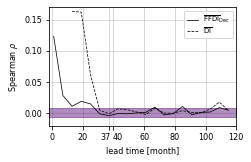

In [20]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.02,
              'legend.handlelength' : 1.5}

with plt.rc_context(rc_context):
    fig = plot_Fig_3(f6_FFDI_corr_samp['FFDI_DEC'], 
                     f6_DI_corr_samp['precip_ann'], 
                     null_corr['FFDI_DEC'],
                     min_lead=37)
    
fig.savefig(f'./figures/independence.pdf', format='pdf',
            bbox_inches='tight')

## Check that removing the ensemble mean trend doesn't have much effect on the correction values

In [21]:
def remove_ensemble_mean_trend(da, ensemble_dim='ensemble', init_date_dim='init_date'):
    import xarray as xr
    """ Remove the ensemble mean trend along the init_date dimension """
    # polyfit doesn't work nicely with cftime objects so convert to np.datetime64
    da = da.assign_coords({init_date_dim: xr.coding.times.cftime_to_nptime(da[init_date_dim])})
    
    ensemble_mean_trend = da.mean(ensemble_dim).polyfit(dim=init_date_dim, deg=1)
    ensemble_mean_trend_fit = xr.polyval(
        da[init_date_dim], ensemble_mean_trend.polyfit_coefficients)
    return da - ensemble_mean_trend_fit

In [22]:
f6_FFDI_stacked_notrend = remove_ensemble_mean_trend(
    f6_FFDI_stacked['FFDI_DEC']).to_dataset(name='FFDI_DEC')

f6_DI_stacked_notrend = remove_ensemble_mean_trend(
    f6_DI_stacked['precip_ann']).to_dataset(name='precip_ann')

f6_FFDI_corr_samp_notrend = f6_FFDI_stacked_notrend.groupby(
    'init_date.month').map(
    my.mean_correlation_ensemble_combinations)
f6_FFDI_corr_samp_notrend = by_month_to_single_lead(f6_FFDI_corr_samp_notrend)

f6_DI_corr_samp_notrend = f6_DI_stacked_notrend.groupby(
    'init_date.month').map(
    my.mean_correlation_ensemble_combinations)
f6_DI_corr_samp_notrend = by_month_to_single_lead(f6_DI_corr_samp_notrend)

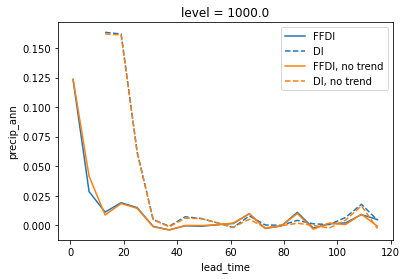

In [23]:
f6_FFDI_corr_samp['FFDI_DEC'].plot(color='C0', linestyle='-', label='FFDI')
f6_DI_corr_samp['precip_ann'].plot(color='C0', linestyle='--', label='DI')

f6_FFDI_corr_samp_notrend['FFDI_DEC'].plot(color='C1', linestyle='-', label='FFDI, no trend')
f6_DI_corr_samp_notrend['precip_ann'].plot(color='C1', linestyle='--', label='DI, no trend')
plt.legend();

--------
# Fidelity testing using KS tests

### Keep only independent leads

In [12]:
f6_FFDI_indep = f6_FFDI.where(f6_FFDI.lead_time >= 37, drop=True)
f6_FFDI_indep = f6_FFDI_indep.assign_coords({
    'lead_time': f6_FFDI_indep.lead_time.where(f6_FFDI_indep.lead_time >= 37)})

f5_FFDI_indep = f5_FFDI.where(f5_FFDI.lead_time >= 37, drop=True)
f5_FFDI_indep = f5_FFDI_indep.assign_coords({
    'lead_time': f5_FFDI_indep.lead_time.where(f5_FFDI_indep.lead_time >= 37)})

In [13]:
f6_DI_indep = f6_DI.where(f6_DI.lead_time >= 37, drop=True)
f6_DI_indep = f6_DI_indep.assign_coords({
    'lead_time': f6_DI_indep.lead_time.where(f6_DI_indep.lead_time >= 37)})

f5_DI_indep = f5_DI.where(f5_DI.lead_time >= 37, drop=True)
f5_DI_indep = f5_DI_indep.assign_coords({
    'lead_time': f5_DI_indep.lead_time.where(f5_DI_indep.lead_time >= 37)})

In [14]:
f6_nino34_indep = f6_nino34.where(f6_nino34.lead_time >= 37, drop=True)
f6_nino34_indep = f6_nino34_indep.assign_coords({
    'lead_time': f6_nino34_indep.lead_time.where(f6_nino34_indep.lead_time >= 37)})

f5_nino34_indep = f5_nino34.where(f5_nino34.lead_time >= 37, drop=True)
f5_nino34_indep = f5_nino34_indep.assign_coords({
    'lead_time': f5_nino34_indep.lead_time.where(f5_nino34_indep.lead_time >= 37)})

In [15]:
f6_dmi_indep = f6_dmi.where(f6_dmi.lead_time >= 37, drop=True)
f6_dmi_indep = f6_dmi_indep.assign_coords({
    'lead_time': f6_dmi_indep.lead_time.where(f6_dmi_indep.lead_time >= 37)})

f5_dmi_indep = f5_dmi.where(f5_dmi.lead_time >= 37, drop=True)
f5_dmi_indep = f5_dmi_indep.assign_coords({
    'lead_time': f5_dmi_indep.lead_time.where(f5_dmi_indep.lead_time >= 37)})

In [16]:
f6_sam_indep = f6_sam.where(f6_sam.lead_time >= 37, drop=True)
f6_sam_indep = f6_sam_indep.assign_coords({
    'lead_time': f6_sam_indep.lead_time.where(f6_sam_indep.lead_time >= 37)})

f5_sam_indep = f5_sam.where(f5_sam.lead_time >= 37, drop=True)
f5_sam_indep = f5_sam_indep.assign_coords({
    'lead_time': f5_sam_indep.lead_time.where(f5_sam_indep.lead_time >= 37)})

In [17]:
jra_FFDI, awap_DI, had_nino34, had_dmi, jra_sam = xr.align(
    jra_FFDI, awap_DI, had_nino34, had_dmi, jra_sam)

### Perform 1D KS tests on FFDI, DI, and drivers

#### Test f6 data

In [18]:
f6_KS = my.fidelity_KS_univariate(
        xr.merge([f6_FFDI_indep.compute(), 
                  f6_DI_indep.compute(),
                  f6_nino34_indep.compute(),
                  f6_dmi_indep.compute(),
                  f6_sam_indep.compute()]),
        xr.merge([jra_FFDI.compute(), 
                  awap_DI.compute(),
                  had_nino34.drop('month').compute(),
                  had_dmi.drop('month').compute(),
                  jra_sam.compute()]),
        slice('2014','2020'),
        by_lead=False)

#### Test f5 data

In [19]:
f5_KS = my.fidelity_KS_univariate(
        xr.merge([f5_FFDI_indep.compute(), 
                  f5_DI_indep.compute(),
                  f5_nino34_indep.compute(),
                  f5_dmi_indep.compute(),
                  f5_sam_indep.compute()]),
        xr.merge([jra_FFDI.compute(), 
                  awap_DI.compute(),
                  had_nino34.drop('month').compute(),
                  had_dmi.drop('month').compute(),
                  jra_sam.compute()]),
        slice('1989','2020'),
        by_lead=False)

### Perform 2D KS tests on FFDI and DI
Takes ~ 9 hours to compute with 10_000 bootstraps using 48 cores

In [20]:
%%time
compute = False

if compute:
    f6_KS2 = my.fidelity_KS_bivariate(
        f6_FFDI_indep.compute(),
        f6_DI_indep.compute(),
        jra_FFDI.compute(),
        awap_DI.compute(),
        slice('2014','2020'),
        by_lead=False, 
        n_bootstraps=N_BOOTSTRAPS)
    f6_KS2.to_netcdf('data/CAFE-f6_KS-test.nc')

    f6_KS2_bylead = my.fidelity_KS_bivariate(
        f6_FFDI_indep.compute(),
        f6_DI_indep.compute(),
        jra_FFDI.compute(),
        awap_DI.compute(),
        slice('2005','2020'),
        by_lead=True, 
        n_bootstraps=N_BOOTSTRAPS)
    f6_KS2_bylead.to_netcdf('data/CAFE-f6_KS-test-bylead.nc')
    
    f5_KS2 = my.fidelity_KS_bivariate(
        f5_FFDI_indep.compute(),
        f5_DI_indep.compute(),
        jra_FFDI.compute(),
        awap_DI.compute(),
        slice('1989','2020'),
        by_lead=False, 
        n_bootstraps=N_BOOTSTRAPS)
    f5_KS2.to_netcdf('data/CAFE-f5_KS-test.nc')

    f5_KS2_bylead = my.fidelity_KS_bivariate(
        f5_FFDI_indep.compute(),
        f5_DI_indep.compute(),
        jra_FFDI.compute(),
        awap_DI.compute(),
        slice('1989','2020'),
        by_lead=True, 
        n_bootstraps=N_BOOTSTRAPS)
    f5_KS2_bylead.to_netcdf('data/CAFE-f5_KS-test-bylead.nc') 
else:
    f6_KS2 = xr.open_dataset('data/CAFE-f6_KS-test.nc')
    f6_KS2_bylead = xr.open_dataset('data/CAFE-f6_KS-test-bylead.nc')
    f5_KS2 = xr.open_dataset('data/CAFE-f5_KS-test.nc')
    f5_KS2_bylead = xr.open_dataset('data/CAFE-f5_KS-test-bylead.nc')

CPU times: user 13.8 ms, sys: 4.4 ms, total: 18.2 ms
Wall time: 20.5 ms


## Plot Fig Supp2 for paper

In [33]:
def plot_Fig_S2(f6_nino34, f5_nino34, had_nino34, nino34_KS_pvalues,
                f6_dmi, f5_dmi, had_dmi, dmi_KS_pvalues, 
                f6_sam, f5_sam, jra_sam, sam_KS_pvalues, 
                figsize=(13,10)):
    from matplotlib.collections import LineCollection
    from matplotlib.legend_handler import HandlerLine2D, HandlerLineCollection
    
    f6_period = slice('2014','2020')
    f5_period = slice('1989','2020')

    nbins = 25
    ylim = (-1.4, 1.4)
    yticks = (-1,0,1)

    lead_colors = pl.cm.magma(np.linspace(0,1,20))[5:]

    def _bin_centres(bins):
            """ Bin centres from bin edges """
            return (bins[:-1] + bins[1:])/2

    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(ncols=3, nrows=1, figure=fig)

    # NINO 3.4 =====================================================
    ax = fig.add_subplot(gs[0, 0])

    f6_super = my.stack_super_ensemble(f6_nino34.sel(time=f6_period), by_lead=False)
    f6_super_bylead = my.stack_super_ensemble(f6_nino34.sel(time=f6_period), by_lead=True)
    f5_super = my.stack_super_ensemble(f6_nino34.sel(time=f5_period), by_lead=False)
    f5_super_bylead = my.stack_super_ensemble(f5_nino34.sel(time=f5_period), by_lead=True)
    obsv_f6_super = had_nino34.sel(time=f6_period)
    obsv_f5_super = had_nino34.sel(time=f5_period)

    # f6 -----
    dat = f6_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), model_pdf / model_pdf_max, 
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f6_super_bylead.lead_time):
        dat = f6_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), model_pdf / model_pdf_max, 
                color=lead_colors[idc], linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f6_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max() , width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.97, f'{nino34_KS_pvalues[0].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    # f5 -----
    dat = f5_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max, 
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f5_super_bylead.lead_time):
        dat = f5_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max, color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f5_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.09, f'{nino34_KS_pvalues[1].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    ax.set_xlabel('SOND Nino 3.4')
    ax.set_ylabel(r'pdf / pdf$_{\mathrm{max}}$')
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels([abs(y) for y in yticks])
    
    ax.text(-0.06, 1.02, r'$\bf{a}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    # DMI =====================================================
    ax = fig.add_subplot(gs[0, 1])

    f6_super = my.stack_super_ensemble(f6_dmi.sel(time=f6_period), by_lead=False)
    f6_super_bylead = my.stack_super_ensemble(f6_dmi.sel(time=f6_period), by_lead=True)
    f5_super = my.stack_super_ensemble(f6_dmi.sel(time=f5_period), by_lead=False)
    f5_super_bylead = my.stack_super_ensemble(f5_dmi.sel(time=f5_period), by_lead=True)
    obsv_f6_super = had_dmi.sel(time=f6_period)
    obsv_f5_super = had_dmi.sel(time=f5_period)

    # f6 -----
    dat = f6_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), model_pdf / model_pdf_max,
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f6_super_bylead.lead_time):
        dat = f6_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), model_pdf / model_pdf_max, 
                color=lead_colors[idc], linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f6_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.97, f'{dmi_KS_pvalues[0].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    # f5 -----
    dat = f5_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max,
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f5_super_bylead.lead_time):
        dat = f5_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max,
                color=lead_colors[idc], linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f5_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.09, f'{dmi_KS_pvalues[1].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    ax.set_xlabel('SON DMI')
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    
    ax.text(-0.06, 1.02, r'$\bf{b}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    # Legend =========================================================
    class HandlerColorLineCollection(HandlerLineCollection):
        def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
            HandlerLineCollection.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
            self._xoffset = x_offset
        def create_artists(self, legend, artist ,xdescent, ydescent,
                            width, height, fontsize,trans):
            x = np.linspace(0,1.2*width,self.get_numpoints(legend)+1) - self._xoffset
            y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=artist.cmap,
                         transform=trans)
            lc.set_array(x)
            lc.set_linewidth(artist.get_linewidth())
            return [lc]

    class HandlerXoffset(HandlerLine2D):
        def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
            HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
            self._xoffset = x_offset
        def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
            numpoints = self.get_numpoints(legend)
            if numpoints > 1:
                xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                    width - self._marker_pad * fontsize,
                                    numpoints) - self._xoffset
                xdata_marker = xdata
            elif numpoints == 1:
                xdata = np.linspace(-xdescent, width, 2) - self._xoffset
                xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]
            return xdata, xdata_marker

    xpoints = np.linspace(0, 1, len(f6_super_bylead.lead_time))
    points = np.array([xpoints, np.ones_like(xpoints)]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, 
                        cmap=matplotlib.colors.ListedColormap(lead_colors, name='custom_cmap'),
                        clip_on=False, linewidth=2)
    lm, = ax.plot(np.nan, np.nan, linestyle='--', linewidth=1, color='k')
    ho, = ax.plot(np.nan, np.nan, linewidth=0, marker='s', markersize=4, 
                  markeredgewidth=0.5, markerfacecolor='w', markeredgecolor='k')
    l = ax.legend([(ho), (lm), lc], ['   Observations', 
                                     '   Model: all leads', 
                                     r'   Model: by lead'],
                  handler_map={ho: HandlerXoffset(x_offset=-1.2),
                               lm: HandlerXoffset(x_offset=-1),
                               lc: HandlerColorLineCollection(numpoints=10, x_offset=-0.7)}, 
                  framealpha=1,
                  bbox_to_anchor=[0,0,1,1])
    for text in l.get_texts():
        text.set_color("k")
        
    # SAM =====================================================
    ax = fig.add_subplot(gs[0, 2])

    f6_super = my.stack_super_ensemble(f6_sam.sel(time=f6_period), by_lead=False)
    f6_super_bylead = my.stack_super_ensemble(f6_sam.sel(time=f6_period), by_lead=True)
    f5_super = my.stack_super_ensemble(f6_sam.sel(time=f5_period), by_lead=False)
    f5_super_bylead = my.stack_super_ensemble(f5_sam.sel(time=f5_period), by_lead=True)
    obsv_f6_super = jra_sam.sel(time=f6_period)
    obsv_f5_super = jra_sam.sel(time=f5_period)

    # f6 -----
    dat = f6_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), model_pdf / model_pdf_max,
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f6_super_bylead.lead_time):
        dat = f6_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), model_pdf / model_pdf_max,
                color=lead_colors[idc], linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f6_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.97, f'{sam_KS_pvalues[0].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    # f5 -----
    dat = f5_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
    model_pdf_max = model_pdf.max()
    ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max,
            color='k', linewidth=1, linestyle='--', label='all leads', zorder=3)
    for idc, lead in enumerate(f5_super_bylead.lead_time):
        dat = f5_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
        ax.plot(_bin_centres(bins), -model_pdf / model_pdf_max,
                color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    obsv_pdf, bins = np.histogram(obsv_f5_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), -obsv_pdf / obsv_pdf.max(), width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.text(0.03, 0.09, f'{sam_KS_pvalues[1].item():.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    ax.set_xlabel(r'SOND SAM$_\mathrm{I}$')
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])

    ax.text(-0.06, 1.02, r'$\bf{c}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)
    
    plt.subplots_adjust(wspace=0.1)
    
    return fig

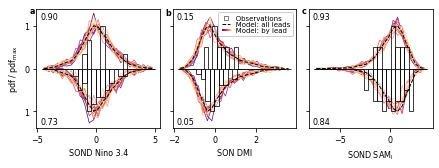

In [34]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.1,
              'legend.labelspacing' : 0.03,
              'legend.handletextpad': -0.1,
              'legend.handlelength' : 1.2}

with plt.rc_context(rc_context):
    fig = plot_Fig_S2(
        f6_nino34_indep['nino34_SOND'].compute(),
        f5_nino34_indep['nino34_SOND'].compute(),
        had_nino34['nino34_SOND'].compute(),
        (f6_KS['nino34_SOND_p-value'], f5_KS['nino34_SOND_p-value']),
        f6_dmi_indep['dmi_SON'].compute(),
        f5_dmi_indep['dmi_SON'].compute(),
        had_dmi['dmi_SON'].compute(),
        (f6_KS['dmi_SON_p-value'], f5_KS['dmi_SON_p-value']),
        f6_sam_indep['sam_SOND'].compute(),
        f5_sam_indep['sam_SOND'].compute(),
        jra_sam['sam_SOND'].compute(),
        (f6_KS['sam_SOND_p-value'], f5_KS['sam_SOND_p-value']),
        figsize=(7.1, 2.2))
    
fig.savefig(f'./figures/fidelity_drivers.pdf', format='pdf',
            bbox_inches='tight')

## Plot Fig 4 for paper

In [21]:
def plot_Fig_4(f6_FFDI, f6_DI, f5_FFDI, f5_DI, obsv_FFDI, obsv_DI,
               f6_KS2,  f6_KS2_bylead, f5_KS2, f5_KS2_bylead, figsize=(7,8.5)):
    from matplotlib.collections import LineCollection
    from matplotlib.legend_handler import HandlerLine2D, HandlerLineCollection

    nbins = 30
    alpha = 5
    xlim = [0.3, 17]
    ylim = [360, 1680]
    xticks = range(0,18,2)
    yticks = range(400,1800,200)

    lead_colors = pl.cm.magma(np.linspace(0,1,20))[5:]

    fill1 = cm.get_cmap('magma')(0.6)
    fill2 = cm.get_cmap('magma')(0.3)
    alpha1 = 0.55
    alpha2 = 0.5

    def _bin_centres(bins):
        """ Bin centres from bin edges """
        return (bins[:-1] + bins[1:])/2

    def kde(x, y, npoints=60):
        """ 2D kernel density estimate """
        from scipy import stats
        x_I, y_I = np.mgrid[0.5*x.min().values:2*x.max().values:complex(npoints), 
                            0.5*y.min().values:2*y.max().values:complex(npoints)]
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        positions = np.vstack([x_I.ravel(), y_I.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)
        KDE = np.reshape(kernel(positions).T, x_I.shape)
        return x_I, y_I, KDE

    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(ncols=3, nrows=4, figure=fig, 
                          width_ratios=[1,3,2], height_ratios=[1,3,3,1])

    # f6 joint distribution =========================================================
    period = slice('2014','2020')
    levels = [0.5e-4, 2e-4, 4e-4]

    ax = fig.add_subplot(gs[1, 1])
    ax.grid(zorder=-2, linewidth=0.5)
    fcst_FFDI_super = my.stack_super_ensemble(f6_FFDI.sel(time=period), by_lead=False)
    fcst_FFDI_super_bylead = my.stack_super_ensemble(f6_FFDI.sel(time=period), by_lead=True)
    fcst_DI_super = my.stack_super_ensemble(f6_DI.sel(time=period), by_lead=False)
    fcst_DI_super_bylead = my.stack_super_ensemble(f6_DI.sel(time=period), by_lead=True)

    obsv_FFDI_super = obsv_FFDI.sel(time=period)
    obsv_DI_super = obsv_DI.sel(time=period)

    ax.scatter(fcst_FFDI_super, fcst_DI_super, 
               s=20, lw=0.5, facecolor=[0.8,0.8,0.8], edgecolor=[0.5,0.5,0.5], zorder=2)

    for idc, lead in enumerate(fcst_FFDI_super_bylead.lead_time):
        X_kde, Y_kde, Z_kde = kde(fcst_FFDI_super_bylead.sel(lead_time=lead, method='nearest'), 
                                  fcst_DI_super_bylead.sel(lead_time=lead, method='nearest'))
        cs = ax.contour(X_kde, Y_kde, Z_kde, levels, linestyles='-', linewidths=0.75, colors=[lead_colors[idc]])
    X_kde, Y_kde, Z_kde = kde(fcst_FFDI_super, fcst_DI_super)
    cs = ax.contour(X_kde, Y_kde, Z_kde, levels, linestyles='--', linewidths=1, colors='k')

    ax.scatter(obsv_FFDI_super, obsv_DI_super, 
               s=30, lw=0.5, facecolor='w', edgecolor='k', zorder=2)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.invert_yaxis()
    ax.text(0.01, 0.99, r'$\bf{a}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # Legend =========================================================
    class HandlerColorLineCollection(HandlerLineCollection):
        def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
            HandlerLineCollection.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
            self._xoffset = x_offset
        def create_artists(self, legend, artist ,xdescent, ydescent,
                            width, height, fontsize,trans):
            x = np.linspace(0,2.1*width,self.get_numpoints(legend)+1) - self._xoffset
            y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap=artist.cmap,
                         transform=trans)
            lc.set_array(x)
            lc.set_linewidth(artist.get_linewidth())
            return [lc]

    class HandlerXoffset(HandlerLine2D):
        def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
            HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
            self._xoffset = x_offset
        def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
            numpoints = self.get_numpoints(legend)
            if numpoints > 1:
                xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                    width - self._marker_pad * fontsize,
                                    numpoints) - self._xoffset
                xdata_marker = xdata
            elif numpoints == 1:
                xdata = np.linspace(-xdescent, width, 2) - self._xoffset
                xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]
            return xdata, xdata_marker

    xpoints = np.linspace(0, 1, len(fcst_FFDI_super_bylead.lead_time))
    points = np.array([xpoints, np.ones_like(xpoints)]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, 
                        cmap=matplotlib.colors.ListedColormap(lead_colors, name='custom_cmap'),
                        clip_on=False, linewidth=2)
    sm, = ax.plot(np.nan, np.nan, linewidth=0, marker='o', markersize=4.5, 
                  markeredgewidth=0.5, markerfacecolor=[0.8,0.8,0.8], markeredgecolor=[0.5,0.5,0.5])
    lm, = ax.plot(np.nan, np.nan, linestyle='--', linewidth=1, color='k')
    so, = ax.plot(np.nan, np.nan, linewidth=0, marker='o', markersize=4.5, 
                  markeredgewidth=0.5, markerfacecolor='w', markeredgecolor='k')
    ho, = ax.plot(np.nan, np.nan, linewidth=0, marker='s', markersize=4, 
                  markeredgewidth=0.5, markerfacecolor='w', markeredgecolor='k')
    l = ax.legend([(so, ho), (lm, sm), lc], ['   Observations', 
                                             '   Model: all leads', 
                                            r'   Model: by lead'],
                  handler_map={so:HandlerXoffset(x_offset=-1), ho:HandlerXoffset(x_offset=-9),
                               lm:HandlerXoffset(x_offset=-1), sm:HandlerXoffset(x_offset=-11),
                               lc:HandlerColorLineCollection(numpoints=10, x_offset=0)}, framealpha=1, loc='lower right', 
                  bbox_to_anchor=[0,0,1,1])
    for text in l.get_texts():
        text.set_color("k")

    # f6 marginal distributions =========================================================
    ax = fig.add_subplot(gs[0, 1])
    for idc, lead in enumerate(fcst_FFDI_super_bylead.lead_time):
        dat = fcst_FFDI_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
        ax.plot(_bin_centres(bins), model_pdf, color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    dat = fcst_FFDI_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
    ax.plot(_bin_centres(bins), model_pdf, color='k', linewidth=1, linestyle='--', label='all leads')
    obsv_pdf, bins = np.histogram(obsv_FFDI_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), obsv_pdf, width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), obsv_pdf, width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.text(0.01, 0.97, r'$\bf{b}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    ax = fig.add_subplot(gs[1, 0])
    for idc, lead in enumerate(fcst_DI_super_bylead.lead_time):
        dat = fcst_DI_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
        ax.plot(model_pdf, _bin_centres(bins), color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    dat = fcst_DI_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
    ax.plot(model_pdf, _bin_centres(bins), color='k', linewidth=1, linestyle='--', label='all leads')
    obsv_pdf, bins = np.histogram(obsv_DI_super, bins=bins, density=True)
    height = np.diff(_bin_centres(bins))[0]
    ax.barh(_bin_centres(bins), obsv_pdf, height, 
            facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.barh(_bin_centres(bins), obsv_pdf, height, 
            facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.set_ylim(ylim)
    ax.set_xlim((0,0.005))
    ax.set_yticks(yticks)
    ax.set_xticks([0, 0.005])
    ax.set_xticklabels([])
    ax.set_ylabel(r'$\overline{\mathrm{DI}}$')
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.text(0.03, 0.99, r'$\bf{c}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # f5 joint distribution =========================================================
    period = slice('1989','2020')
    levels = [0.5e-4, 2e-4, 4e-4]

    ax = fig.add_subplot(gs[2, 1])
    ax.grid(zorder=-2, linewidth=0.5)
    fcst_FFDI_super = my.stack_super_ensemble(f5_FFDI.sel(time=period), by_lead=False)
    fcst_FFDI_super_bylead = my.stack_super_ensemble(f5_FFDI.sel(time=period), by_lead=True)
    fcst_DI_super = my.stack_super_ensemble(f5_DI.sel(time=period), by_lead=False)
    fcst_DI_super_bylead = my.stack_super_ensemble(f5_DI.sel(time=period), by_lead=True)

    obsv_FFDI_super = obsv_FFDI.sel(time=period)
    obsv_DI_super = obsv_DI.sel(time=period)

    ax.scatter(fcst_FFDI_super, fcst_DI_super, 
               s=20, lw=0.5, facecolor=[0.8,0.8,0.8], edgecolor=[0.5,0.5,0.5], zorder=2)

    for idc, lead in enumerate(fcst_FFDI_super_bylead.lead_time):
        X_kde, Y_kde, Z_kde = kde(fcst_FFDI_super_bylead.sel(lead_time=lead, method='nearest'), 
                                  fcst_DI_super_bylead.sel(lead_time=lead, method='nearest'))
        cs = ax.contour(X_kde, Y_kde, Z_kde, levels, linestyles='-', linewidths=0.75, colors=[lead_colors[idc]])
    X_kde, Y_kde, Z_kde = kde(fcst_FFDI_super, fcst_DI_super)
    cs = ax.contour(X_kde, Y_kde, Z_kde, levels, linestyles='--', linewidths=1, colors='k')

    ax.scatter(obsv_FFDI_super, obsv_DI_super, 
               s=30, lw=0.5, facecolor='w', edgecolor='k', zorder=2)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.invert_yaxis()
    ax.text(0.01, 0.98, r'$\bf{d}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # f5 marginal distributions =========================================================
    ax = fig.add_subplot(gs[3, 1])
    for idc, lead in enumerate(fcst_FFDI_super_bylead.lead_time):
        dat = fcst_FFDI_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
        ax.plot(_bin_centres(bins), model_pdf, color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    dat = fcst_FFDI_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
    ax.plot(_bin_centres(bins), model_pdf, color='k', linewidth=1, linestyle='--', label='all leads')
    obsv_pdf, bins = np.histogram(obsv_FFDI_super, bins=bins, density=True)
    width = np.diff(_bin_centres(bins))[0]
    ax.bar(_bin_centres(bins), obsv_pdf, width=width, 
           facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.bar(_bin_centres(bins), obsv_pdf, width=width, 
           facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.set_xlim(xlim)
    ax.invert_yaxis()
    ax.set_xticks(xticks)
    ax.set_yticks([0, 0.25])
    ax.set_yticklabels(['', 0.25])
    ax.set_xlabel(r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$')
    ax.text(0.01, 0.99, r'$\bf{e}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    ax = fig.add_subplot(gs[2, 0])
    for idc, lead in enumerate(fcst_DI_super_bylead.lead_time):
        dat = fcst_DI_super_bylead.sel(lead_time=lead, method='nearest')
        model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=nbins, density=True)
        ax.plot(model_pdf, _bin_centres(bins), color=lead_colors[idc], 
                linewidth=0.75, label=f'lead {lead.values}')
    dat = fcst_DI_super
    model_pdf, bins = np.histogram(dat[~np.isnan(dat)], bins=bins, density=True)
    ax.plot(model_pdf, _bin_centres(bins), color='k', linewidth=1, linestyle='--', label='all leads')
    obsv_pdf, bins = np.histogram(obsv_DI_super, bins=bins, density=True)
    height = np.diff(_bin_centres(bins))[0]
    ax.barh(_bin_centres(bins), obsv_pdf, height, 
            facecolor='w', edgecolor='none', alpha=0.5, linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.barh(_bin_centres(bins), obsv_pdf, height, 
            facecolor='none', edgecolor='k', linewidth=0.75, linestyle='-', label='obsv', zorder=3)
    ax.set_ylim(ylim)
    ax.set_xlim((0,0.005))
    ax.set_xticks([0, 0.005])
    ax.set_yticks(yticks)
    ax.set_xticklabels(['0.00      ', 0.005])
    ax.set_ylabel(r'$\overline{\mathrm{DI}}$')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.text(0.03, 0.98, r'$\bf{f}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # KS distributions per lead =========================================================
    shift = 2     # Vertical gap between distributions
    squash = 1.07 # Scale factor when normalising height of distributions

    ax = fig.add_subplot(gs[1:, 2])
    f6_ks_bins = np.linspace(-0.15, 0.45, 40)
    f5_ks_bins = np.linspace(-0.15, 0.25, 40)

    for idy, lead in enumerate(f6_KS2_bylead.lead_time):
        # f6 distributions -----
        f6_K = f6_KS2_bylead['K'].sel(lead_time=lead, method='nearest')
        f6_K_obs = f6_KS2_bylead['K_obs'].sel(lead_time=lead, method='nearest')
        f6_K_pdf, f6_K_bins = np.histogram(f6_K - f6_K_obs, bins=nbins, density=True)
        f6_K_pdf = f6_K_pdf / (squash * f6_K_pdf.max()) # Normalise height

        f6_a = (f6_K - f6_K_obs).quantile(q=1-alpha/100, dim='k').values
        f6_Kd_max = (f6_K - f6_K_obs).quantile(q=0.995, dim='k').values
        f6_Kd_min = (f6_K - f6_K_obs).quantile(q=0.0, dim='k').values
        f6_conf = (f6_K > f6_K_obs).mean().values

        to_fill_x = np.concatenate((_bin_centres(f6_K_bins)[_bin_centres(f6_K_bins) <= f6_a], [f6_a]))
        to_fill_y = np.concatenate(((f6_K_pdf+(idy*shift))[_bin_centres(f6_K_bins) <= f6_a],
                                    [interp1d(_bin_centres(f6_K_bins), f6_K_pdf+(idy*shift))(f6_a)]))
        ax.fill_between(to_fill_x, idy*shift, to_fill_y, 
                        color=fill1, alpha=alpha1, ec='k', lw=0.5)

        # f5 distributions -----
        f5_K = f5_KS2_bylead['K'].sel(lead_time=lead, method='nearest')
        f5_K_obs = f5_KS2_bylead['K_obs'].sel(lead_time=lead, method='nearest')
        f5_K_pdf, f5_K_bins = np.histogram(f5_K - f5_K_obs, bins=nbins, density=True)
        f5_K_pdf = f5_K_pdf / (squash * f5_K_pdf.max()) # Normalise height

        f5_a = (f5_K - f5_K_obs).quantile(q=1-alpha/100, dim='k').values
        f5_Kd_max = (f5_K - f5_K_obs).quantile(q=0.995, dim='k').values
        f5_Kd_min = (f5_K - f5_K_obs).quantile(q=0.0, dim='k').values
        f5_conf = (f5_K > f5_K_obs).mean().values

        to_fill_x = np.concatenate((_bin_centres(f5_K_bins)[_bin_centres(f5_K_bins) <= f5_a], [f5_a]))
        to_fill_y = np.concatenate(((-f5_K_pdf+(idy*shift))[_bin_centres(f5_K_bins) <= f5_a],
                                    [interp1d(_bin_centres(f5_K_bins), -f5_K_pdf+(idy*shift))(f5_a)]))
        ax.fill_between(to_fill_x, to_fill_y, idy*shift,  
                        color=fill2, alpha=alpha2, ec='k', lw=0.5)

        ax.plot([min(f6_Kd_min, f5_Kd_min), max(f6_Kd_max, f5_Kd_max)], [idy*shift, idy*shift], color='k', linewidth=0.75)

        ax.plot(_bin_centres(f6_K_bins)[(_bin_centres(f6_K_bins) <= f6_Kd_max) & (_bin_centres(f6_K_bins) >= f6_Kd_min)], 
                (f6_K_pdf+(idy*shift))[(_bin_centres(f6_K_bins) <= f6_Kd_max) & (_bin_centres(f6_K_bins) >= f6_Kd_min)], 
                color='k', linewidth=0.75, linestyle='-')
        ax.plot(_bin_centres(f5_K_bins)[(_bin_centres(f5_K_bins) <= f5_Kd_max) & (_bin_centres(f5_K_bins) >= f5_Kd_min)],
                (-f5_K_pdf+(idy*shift))[(_bin_centres(f5_K_bins) <= f5_Kd_max) & (_bin_centres(f5_K_bins) >= f5_Kd_min)], 
                color='k', linewidth=0.75, linestyle='-')
        ax.text(f6_Kd_max-0.08, idy*shift+0.4, f'{f6_conf:.2f}', 
                color=fill1, fontsize=rc_context['font.size']-1)
        ax.text(f5_Kd_min-0.05, idy*shift-0.6, f'{f5_conf:.2f}', 
                color=fill2, fontsize=rc_context['font.size']-1)

    ax.set_xlim([-0.25, 0.38])
    ax.set_xticks([-0.25, 0, 0.25])
    ax.plot([0,0], [-1.5*shift, idy*shift+shift], color='k', linewidth=0.75, linestyle='-', alpha=0.8)
    ax.set_ylim([-1*shift+0.7, idy*shift+shift-0.7])
    ax.set_yticks([])
    ax.set_yticks(range(0, idy*shift+shift, shift))
    ax.set_yticklabels([int(l) for l in f6_KS2_bylead.lead_time.values])
    ax.set_ylabel('lead time [months]')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position("right");
    ax.set_xlabel(r'$K - K_{\mathrm{obs}}$');
    ax.text(0.02, 0.995, r'$\bf{h}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # KS distributions all leads =========================================================
    ax = fig.add_subplot(gs[0, 2])

    f6_K = f6_KS2['K']
    f6_K_obs = f6_KS2['K_obs']
    f6_K_pdf, f6_K_bins = np.histogram(f6_K - f6_K_obs, bins=nbins, density=True)
    f6_K_pdf = f6_K_pdf / (squash * f6_K_pdf.max()) # Normalise height    
    f6_a = (f6_K - f6_K_obs).quantile(q=1-alpha/100, dim='k').values
    f6_Kd_max = (f6_K - f6_K_obs).quantile(q=0.995, dim='k').values
    f6_Kd_min = (f6_K - f6_K_obs).quantile(q=0.0, dim='k').values
    f6_conf = (f6_K > f6_K_obs).mean().values

    to_fill_x = np.concatenate((_bin_centres(f6_K_bins)[_bin_centres(f6_K_bins) <= f6_a], [f6_a]))
    to_fill_y = np.concatenate(((f6_K_pdf)[_bin_centres(f6_K_bins) <= f6_a],
                                [interp1d(_bin_centres(f6_K_bins), f6_K_pdf)(f6_a)]))
    ax.fill_between(to_fill_x, 0, to_fill_y, 
                    color=fill1, alpha=alpha1, ec='k', lw=0.5)

    f5_K = f5_KS2['K']
    f5_K_obs = f5_KS2['K_obs']
    f5_K_pdf, f5_K_bins = np.histogram(f5_K - f5_K_obs, bins=nbins, density=True)
    f5_K_pdf = f5_K_pdf / (squash * f5_K_pdf.max()) # Normalise height    
    f5_a = (f5_K - f5_K_obs).quantile(q=1-alpha/100, dim='k').values
    f5_Kd_max = (f5_K - f5_K_obs).quantile(q=0.995, dim='k').values
    f5_Kd_min = (f5_K - f5_K_obs).quantile(q=0.0, dim='k').values
    f5_conf = (f5_K > f5_K_obs).mean().values

    to_fill_x = np.concatenate((_bin_centres(f5_K_bins)[_bin_centres(f5_K_bins) <= f5_a], [f5_a]))
    to_fill_y = np.concatenate(((-f5_K_pdf)[_bin_centres(f5_K_bins) <= f5_a],
                                [interp1d(_bin_centres(f5_K_bins), -f5_K_pdf)(f5_a)]))
    ax.fill_between(to_fill_x, to_fill_y, 0,  
                    color=fill2, alpha=alpha2, ec='k', lw=0.5)

    ax.plot([min(f6_Kd_min, f5_Kd_min), max(f6_Kd_max, f5_Kd_max)], [0, 0], color='k', linewidth=0.75)

    ax.plot(_bin_centres(f6_K_bins)[(_bin_centres(f6_K_bins) <= f6_Kd_max) & (_bin_centres(f6_K_bins) >= f6_Kd_min)], 
            (f6_K_pdf)[(_bin_centres(f6_K_bins) <= f6_Kd_max) & (_bin_centres(f6_K_bins) >= f6_Kd_min)], 
            color='k', linewidth=0.75, linestyle='-')
    ax.plot(_bin_centres(f5_K_bins)[(_bin_centres(f5_K_bins) <= f5_Kd_max) & (_bin_centres(f5_K_bins) >= f5_Kd_min)],
            (-f5_K_pdf)[(_bin_centres(f5_K_bins) <= f5_Kd_max) & (_bin_centres(f5_K_bins) >= f5_Kd_min)], 
            color='k', linewidth=0.75, linestyle='-')
    ax.text(f6_Kd_max-0.08, 0.4, f'{f6_conf:.2f}', 
            color=fill1, fontsize=rc_context['font.size']-1)
    ax.text(f5_Kd_min-0.05, -0.6, f'{f5_conf:.2f}', 
            color=fill2, fontsize=rc_context['font.size']-1)

    ax.set_xlim([-0.25, 0.38])
    ax.set_xticks([-0.25, 0, 0.25])
    ax.plot([0,0], [-1.5, 1.5], color='k', linewidth=0.75, linestyle='-', alpha=0.8)
    ax.set_ylim([-1.2, 1.2])
    ax.set_yticks([])
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position("right");
    ax.set_xlabel(r'$K - K_{\mathrm{obs}}$');
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position("top");
    ax.text(0.02, 0.993, r'$\bf{g}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    
    return fig

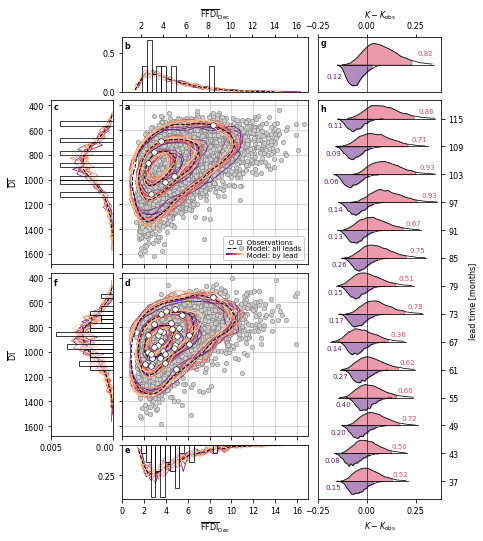

In [22]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.03,
              'legend.handlelength' : 1.3}

with plt.rc_context(rc_context):
    fig = plot_Fig_4(
        f6_FFDI_indep['FFDI_DEC'].compute(), f6_DI_indep['precip_ann'].compute(),
        f5_FFDI_indep['FFDI_DEC'].compute(), f5_DI_indep['precip_ann'].compute(),
        jra_FFDI['FFDI_DEC'].compute(), awap_DI['precip_ann'].compute(),
        f6_KS2, f6_KS2_bylead, f5_KS2, f5_KS2_bylead,
        figsize=(7,8.5))

fig.savefig(f'./figures/fidelity.pdf', format='pdf',
            bbox_inches='tight')

------
# Calculate the correlation between the drivers and the indices

In [23]:
def stack_by_init_ensemble(ds):
    to_concat = []
    for t in ds.time:
        stacked = ds.sel(time=t).stack(sample=['init_date', 'ensemble']).dropna('sample')
        stacked = stacked.assign_coords(sample=range(len(stacked.sample)))
        to_concat.append(stacked)
    return xr.concat(to_concat, dim='time')

period = slice('1989','2020')

FFDI_super = stack_by_init_ensemble(f5_FFDI_indep['FFDI_DEC'].sel(time=period).compute())
DI_super = stack_by_init_ensemble(f5_DI_indep['precip_ann'].sel(time=period).compute())
nino34_super = stack_by_init_ensemble(f5_nino34_indep['nino34_SOND'].sel(time=period).compute())
dmi_super = stack_by_init_ensemble(f5_dmi_indep['dmi_SON'].sel(time=period).compute())
sam_super = stack_by_init_ensemble(f5_sam_indep['sam_SOND'].sel(time=period).compute())

fcst_args = FFDI_super, DI_super, nino34_super, dmi_super, sam_super
obsv_args_full = xr.align(
    jra_FFDI['FFDI_DEC'].compute(), 
    awap_DI['precip_ann'].compute(), 
    had_nino34['nino34_SOND'].compute(), 
    had_dmi['dmi_SON'].compute(), 
    jra_sam['sam_SOND'].compute())
obsv_args = [o.sel(time=period) for o in obsv_args_full]

In [24]:
def get_index_driver_correlations(FFDI, DI, nino34, dmi, sam, dim='time'):
    def _corr(a, b):
        return xs.pearson_r(a, b, dim).values
    data = [[
        _corr(FFDI, nino34),
        _corr(FFDI, dmi),
        _corr(FFDI, sam)], 
            [
        _corr(DI, nino34),
        _corr(DI, dmi),
        _corr(DI, sam)]]
    return xr.DataArray(
        data, 
        coords={'index': [r'$\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$', 
                          r'$\overline{\mathrm{DI}}$'], 
                'driver': [r'SOND NINO 3.4',
                           r'SON DMI', 
                           r'SOND SAM$_\mathrm{I}$']})

In [25]:
corr_obsv = get_index_driver_correlations(*obsv_args, dim='time')
corr_obsv_full = get_index_driver_correlations(*obsv_args_full, dim='time')

corr_fcst = get_index_driver_correlations(*fcst_args, dim=['time', 'sample'])
corr_fcst_bs = my.n_random_resamples(
    *fcst_args,
    samples={'sample': (len(obsv_args[0].time), 1)},
    function=lambda a,b,c,d,e: 
        get_index_driver_correlations(
            *[xr.DataArray(np.diag(x), coords={'time': x.time}) 
              for x in [a,b,c,d,e]], # Hack to randomize sampling for each time
            dim='time'),
    n_repeats=N_BOOTSTRAPS)

## Plot Fig S3 for paper

In [40]:
def plot_Fig_S3(corr_fcst, corr_fcst_bs, corr_obsv, corr_obsv_full, alpha = 5, figsize=(12,5)):
    import matplotlib.patches as mpatches
    from matplotlib.legend_handler import HandlerLine2D
    
    def _bin_centres(bins):
        """ Bin centres from bin edges """
        return (bins[:-1] + bins[1:])/2

    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=figsize)
    labels = [['a','b','c'],['d','e','f']]
    lw = 1

    ylim = (0, 3.2)
    col = cm.get_cmap('magma')(0.3)
    # Loop over indices and drivers and plot correlations
    for idx, i in enumerate(range(2)):
        for idy, d in enumerate(range(3)):
            h, be = np.histogram(corr_fcst_bs.isel(index=i, driver=d), bins=30, density=True)
            b = _bin_centres(be)

            a_max = corr_fcst_bs.isel(index=i, driver=d).quantile(q=1-alpha/200, dim='k').values
            a_min = corr_fcst_bs.isel(index=i, driver=d).quantile(q=alpha/200, dim='k').values

            to_fill_x = np.concatenate(([a_min], b[(b <= a_max) & (b >= a_min)], [a_max]))
            to_fill_y = np.concatenate(([interp1d(b, h)(a_min)],
                                        h[(b <= a_max) & (b >= a_min)],
                                        [interp1d(b, h)(a_max)]))
            axs[i,d].fill_between(to_fill_x, to_fill_y, 0,  
                                  color=col, alpha=0.45, ec='k', lw=0.5)
            axs[i,d].plot(b, h, label='__nolabel__', color='k', lw=0.75)

            axs[i,d].plot([corr_fcst.isel(index=i, driver=d), corr_fcst.isel(index=i, driver=d)],
                    ylim, color=col, linewidth=lw)

            axs[i,d].plot([corr_obsv.isel(index=i, driver=d), corr_obsv.isel(index=i, driver=d)],
                    ylim, linestyle='--', color='k', linewidth=lw)

            axs[i,d].plot([corr_obsv_full.isel(index=i, driver=d), corr_obsv_full.isel(index=i, driver=d)],
                    ylim, linestyle='-.', color='k', linewidth=lw)

            if idx == 0:
                axs[i,d].text(0.5, 1.04, f'{corr_fcst_bs.isel(index=i, driver=d).driver.item()}',
                              horizontalalignment='center', verticalalignment='bottom',
                              transform = axs[i,d].transAxes)
            else:
                axs[i,d].set_xlabel(r'Pearson $\rho$')

            if idy == 0:
                axs[i,d].set_ylabel('pdf') 
                axs[i,d].text(-0.25, 0.48, f'{corr_fcst_bs.isel(index=i, driver=d).index.item()}',
                              horizontalalignment='right', verticalalignment='center',
                              transform = axs[i,d].transAxes)
            axs[i,d].set_ylim(ylim)
            
            axs[i,d].text(0.02, 0.97, r'$\bf{'+labels[i][d]+'}$',
                horizontalalignment='left',
                verticalalignment='top',
                transform = axs[i,d].transAxes)

    # Make legend manually
    l0, = axs[0,0].plot(np.nan, np.nan, color = col, linewidth=lw)
    p0 = mpatches.Patch(facecolor=col, alpha=0.45, linewidth=0)
    pe = mpatches.Patch(color='none', label='Extra label')
    l2, = axs[0,0].plot(np.nan, np.nan, linestyle='--', color='k', linewidth=lw)
    l3, = axs[0,0].plot(np.nan, np.nan, linestyle='-.', color='k', linewidth=lw)
    axs[1,1].legend([pe, (p0, l0), pe, l2, l3], 
                    ['Model', '1989-2020', 'Observ.', '1989-2020', '1958-2020'], 
                    handler_map = {l0 : HandlerLine2D(marker_pad = 0)},
                    loc='upper right')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    
    return fig

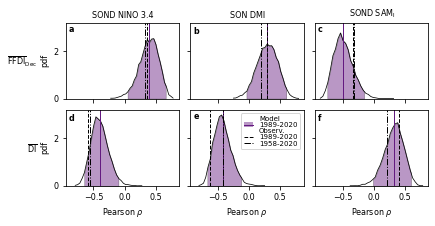

In [41]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.2,
              'legend.labelspacing' : 0.01,
              'legend.handlelength' : 1.4}

with plt.rc_context(rc_context):
    fig = plot_Fig_S3(
        corr_fcst, corr_fcst_bs, corr_obsv, corr_obsv_full, 
        alpha=5, figsize=(6.5, 3))

fig.savefig(f'./figures/index_driver_correlations.pdf', format='pdf',
            bbox_inches='tight')

--------
# End notebook

In [37]:
cluster.close
client.close()